## Introduction

### Problem statement
- There are many reasons why people commit suicide: being a victim of bullying, finding a means of escape from the consequences that their life decisions have brought about, having mental issues... etc. But can one's social-economic environment affect their frame of mind? Would time have anything to do with the result? If so, why?

### Dataset type
- The dataset that I'm using is a csv file from Kaggle, and it depicts information of people who have committed suicide across different countries spanning across a period of time. 
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
- The columns are the following: country, country-year, year, sex, age, suicide no, population, suicides/100k pop, HDI for year, gdp_for_year (\\$), gdp_per_capita (\\$), generation.
- HDI for year is calculated by taking into consideration the birth rate, education, and gross national income as stated in http://wikiprogress.org/articles/initiatives/human-development-index/

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set()
DIMS = (16,6)

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:,.2f}'.format

## Hypothesis
My hypothesis is split into 3 parts:
- I think more females commit suicide
- Higher suicide rates are more likely from poorer countries
- The highest suicide rates is probably from the silent generation 

### Reason
- I think females because: In quite a number of large countries, women are not treated as well as males would be. In China, they used to play favouritism to the males (although globalisation is reducing that). In India and Africa, there is strong male dominance, which has led to many cases of rape / killings of women.
- I think poorer countries because: In countries that do not have good equity, people have little opportunity to make a living. More likely to succumb to the societal pressures.
- I think silent generation because they were given birth in the period of world wars. Times were tough, and there were many scars that they may not have been able to get rid of. The unfavourable social circumstances may have resulted in some undesirable futures that eventually lead to suicide.


## Questions

1) Are females more likely to commit suicide in general?

2) How does suicide rate vary with the developness of a country?

3) How does the suicide rate vary across generations in recent years? Do people in my generation (gen z) commit the deed more often?

4) So how do these columns indicate how likely people are to commit suicide? Can I predict them?

In [2]:
suicide_demo_df = pd.read_csv('data/suicide-overview.csv', sep = ',')
# print(suicide_demo_df.info())
# print(suicide_demo_df.describe())
# suicide_demo_df.head(10)


## Data Cleaning
- I used the below link to label the different generations
https://www.careerplanner.com/Career-Articles/Generations.cfm

In [123]:
suicide_edit_df = suicide_demo_df.copy()
# remove country-year column
suicide_edit_df = suicide_edit_df.drop(['country-year'], axis = 1)
# remove the 'years' from age
suicide_edit_df['age'] = suicide_edit_df['age'].str.rstrip('years').apply(np.str)
# change column types to appropriate datatypes
suicide_edit_df[['country']] = suicide_edit_df['country'].apply(np.str)
suicide_edit_df['gdp_per_capita ($)'] = suicide_edit_df['gdp_per_capita ($)'].apply(np.int)
# remove all na fields to make the playing field even for all variables
suicide_edit_df = suicide_edit_df.dropna()
# replace terms
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('Generation X', 'gen x(1965-1979)')
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('Silent', 'silent(1925-1945)')
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('G.I. Generation', 'g.i gen(1910-1924)')
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('Boomers', 'boomers(1946-1964)')
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('Generation Z', 'gen z(1995-2012)')
suicide_edit_df['generation'] = suicide_edit_df['generation'].replace('Millenials', 'millenials(1980-1994)')
suicide_edit_df.info()
suicide_edit_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8364 entries, 72 to 27819
Data columns (total 11 columns):
country               8364 non-null object
year                  8364 non-null int64
sex                   8364 non-null object
age                   8364 non-null object
suicides_no           8364 non-null int64
population            8364 non-null int64
suicides/100k pop     8364 non-null float64
HDI for year          8364 non-null float64
 gdp_for_year ($)     8364 non-null object
gdp_per_capita ($)    8364 non-null int64
generation            8364 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 784.1+ KB


,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
72,Albania,1995,male,25-34,13,232900,5.58,0.62,"2,424,499,009",835,gen x(1965-1979)
73,Albania,1995,male,55-74,9,178000,5.06,0.62,"2,424,499,009",835,silent(1925-1945)
74,Albania,1995,female,75+,2,40800,4.90,0.62,"2,424,499,009",835,g.i gen(1910-1924)
75,Albania,1995,female,15-24,13,283500,4.59,0.62,"2,424,499,009",835,gen x(1965-1979)
76,Albania,1995,male,15-24,11,241200,4.56,0.62,"2,424,499,009",835,gen x(1965-1979)


## Exploration


### 1) Compare the results of total suicide rates of females against males 

In [13]:
suicide_total_df = suicide_edit_df.copy()
suicide_total_df = suicide_total_df.groupby('sex')['suicides/100k pop'].sum()
suicide_total_df.reset_index()

,sex,suicides/100k pop
0,female,"20,647.36"
1,male,"79,653.19"


### Findings 1: 'Are females more likely commit suicide in general?'
- In contrast to what I was expecting, many more males have committed the deed as compared to females. That's the first point of the hypothesis down. But unexpected results make for more interesting finds.

### 2) Find the relationship between GDP per capita and suicide rate of respective genders

Before doing anything, I just want to lay down certain understandings and expectations that I have:
- Gdp per capita and HDI are both indicators that are used to gauge the developness of a country
- As gdp per capita increases, it indicates that a country is richer
- As HDI increases, it indicates that a country has more welfare and is therefore more developed
- As gdp per capita increases, I will expect HDI to increase. They should have a positive correlation
- In general, a richer country should be more developed. With reference to my hypothesis, a developed country should have lower suicide rates. Since HDI indicates developness, a higher HDI, should also result in lower suicide rates. 

### Before plotting anything with HDI / gdp per capita,  find the relationship between HDI and gdp per capita

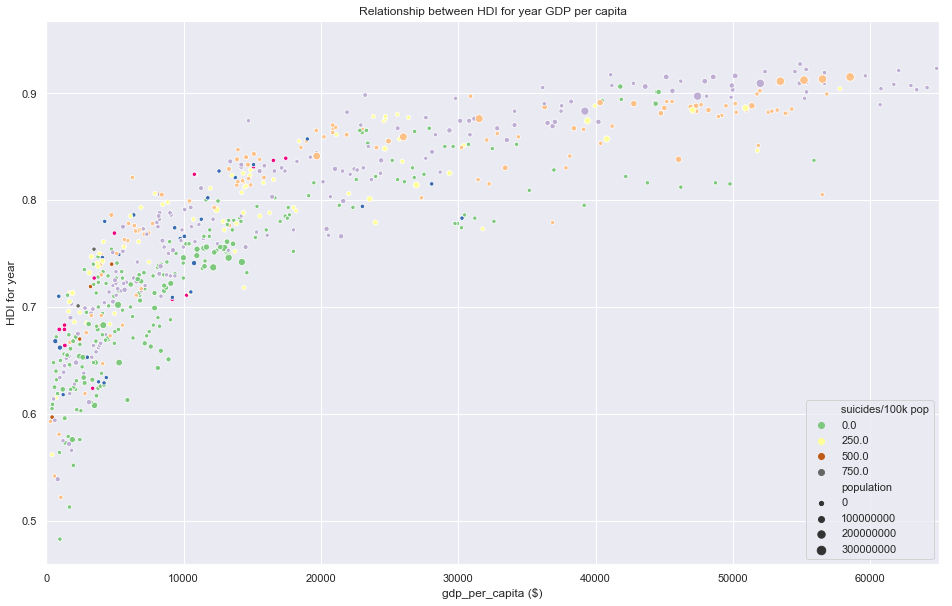

In [32]:
suicide_link_df = suicide_edit_df.copy()
suicide_link_df = suicide_link_df.dropna()
suicide_link_df.head()
# groupby to get the values that I want
suicide_link_df = suicide_link_df.groupby(
    ['country', 'year','HDI for year','gdp_per_capita ($)']
)['population','suicides/100k pop'].sum().reset_index()
# plot 
fig, ax1 = plt.subplots(figsize = (16,10))
sns.scatterplot(
    ax = ax1, hue = suicide_link_df['suicides/100k pop'], palette = 'Accent', size = suicide_link_df['population'],
    x = suicide_link_df['gdp_per_capita ($)'], y = suicide_link_df['HDI for year'])
ax1.set_xlim(0, 65000)
ax1.set_title('Relationship between HDI for year GDP per capita')
plt.show()

- As seen above, HDI is positively related to gdp per capita. As gdp per capita increases, HDI increases at a decreasing rate. The range gdp per capita of 0 - 10000 contains countries with the higher suicides rates. If I plot a relationship between HDI and suicide/100k pop, I should be able to get most suicides between HDI of 0.65 - 0.80 since that is the region where the dots are more concentrated at compared to the other areas.
- Interesting observation is that the smaller countries tend to have larger suicides per 100k
- Unexpectedly, it seems as though the number of suicides/100k pop increases as the HDI increases

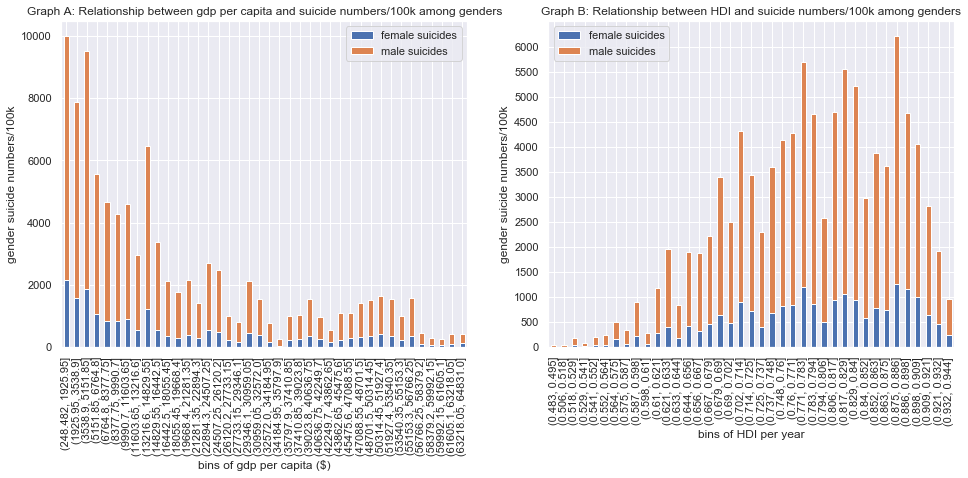

In [76]:
# gender
suicide_gdp_gender_df = suicide_edit_df.copy()
suicide_gdp_gender_df = suicide_gdp_gender_df.groupby(['gdp_per_capita ($)','sex'])['suicides/100k pop'].sum().reset_index()
# limit to gdp per capita to be below 65k since most of the values are below 
suicide_gdp_gender_df['gdp_per_capita ($)'] = suicide_gdp_gender_df[suicide_gdp_gender_df['gdp_per_capita ($)'] <= 65000]
suicide_gdp_gender_df_pivot = pd.pivot_table(
    suicide_gdp_gender_df,
    index = ['gdp_per_capita ($)'],
    columns = ['sex'],
    values = ['suicides/100k pop']
)
suicide_gdp_gender_df_pivot = suicide_gdp_gender_df_pivot.reset_index()
suicide_gdp_gender_df_pivot.columns = ['gdp_per_capita ($)', 'female suicides', 'male suicides']
# split into bins 
suicide_gdp_gender_df_pivot['bins'] = pd.cut(suicide_gdp_gender_df_pivot['gdp_per_capita ($)'], bins = 40)
suicide_gdp_gender_df_pivot = suicide_gdp_gender_df_pivot.set_index('bins').drop('gdp_per_capita ($)', axis = 1)
suicide_gdp_gender_df_pivot = suicide_gdp_gender_df_pivot.groupby('bins').sum()
suicide_gdp_gender_df_pivot.describe()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = DIMS)
suicide_gdp_gender_df_pivot.plot(
    kind = 'bar', ax = ax1, stacked = True
)
ax1.set_xlabel('bins of gdp per capita ($)')
ax1.set_ylabel ('gender suicide numbers/100k')
ax1.set_title ('Graph A: Relationship between gdp per capita and suicide numbers/100k among genders')


# hdi 
suicide_hdi_df = suicide_edit_df.copy()
suicide_hdi_df = suicide_hdi_df.groupby(['HDI for year','sex'])['suicides/100k pop'].sum().reset_index()
suicide_hdi_df.head()
suicide_hdi_df_pivot = pd.pivot_table(
    suicide_hdi_df,
    index = ['HDI for year'],
    columns = ['sex'],
    values = ['suicides/100k pop']
)

suicide_hdi_df_pivot = suicide_hdi_df_pivot.reset_index()
suicide_hdi_df_pivot.columns = ['HDI for year', 'female suicides', 'male suicides']
# split into bins
suicide_hdi_df_pivot['bins for HDI per year'] = pd.cut(suicide_hdi_df_pivot['HDI for year'], bins = 40)
suicide_hdi_df_pivot = suicide_hdi_df_pivot.set_index('bins for HDI per year').drop('HDI for year', axis = 1)
suicide_hdi_df_pivot = suicide_hdi_df_pivot.groupby('bins for HDI per year').sum()
suicide_hdi_df_pivot.plot(
    kind = 'bar', ax = ax2, stacked = True
)
ax2.set_xlabel('bins of HDI per year')
ax2.set_ylabel ('gender suicide numbers/100k')
ax2.set_title ('Graph B: Relationship between HDI and suicide numbers/100k among genders')
ax2.set_yticks(np.arange(0,6500,500))
# plt.axvspan(0.823, 0.881, color = 'yellow')
plt.show()


### Findings 2: How does suicide rate vary with the developness of a country?

- I used bar graphs, with bins, as I thought that this way, the information would be presented in a very detailed manner. People who look at the graphs would be able to tell how suicides are like in different ranges of gdp per capita and HDI respectively. There was simply too many values, so I had to use bins. 

Graph A:
- The impact of a gdp per capita change seems to impact males more significantly than females. Female suicides fluctuates less strongly as compared to that of male suicides. So... I guess men are weaker?
- From the graph, I also see that the number of suicides decrease as the gdp per capita increases. Which makes sense, since the wealthier the country, the better the lives of people right?

Graph B:
- Graph B shows me the opposite of A
- As shown in B, people do not feel any less pressured to commit suicide despite the fact that HDIs are higher. In fact, the highest number of suicide cases come from countries that are quite well to do, according to the HDI (0.8 - 0.9). I did not expect this. 
- Anyways, my underlying assumption that 'higher gdp per capita means more developed which implies higher HDI' is debunked. Having a higher gdp per capita does not mean having a higher HDI. A country can be rich, but if they do not bother investing into the education and healthcare of people, it cannot be counted as a developed country. Qatar is one such case. I remember learning this in Econs class. Evidently, I forgot. lol.
- It's good learning though, supporting question 2) has helped to give me more insight than what I wanted to find out.

Review:
- This discrepancy in results between the HDI and gdp plots is due to the way the indicators are calculated. Gdp per capita is a general indicator while HDI is a more specialised indicator. That being said, both aren't bad indicators. Gdp per capita is a good indicator to use when analysing countries on a more macro level. HDI gives more insight into the initial analysis.
- This is a good example of not assuming results until I have found a concrete relationship using data analysis. If I didn't plot both graphs, and only plotted Graph A, I would've been under the impression that more developed countries have lower suicide rates. 




### 3) Find the number of gender suicides amongst the different generations across the years

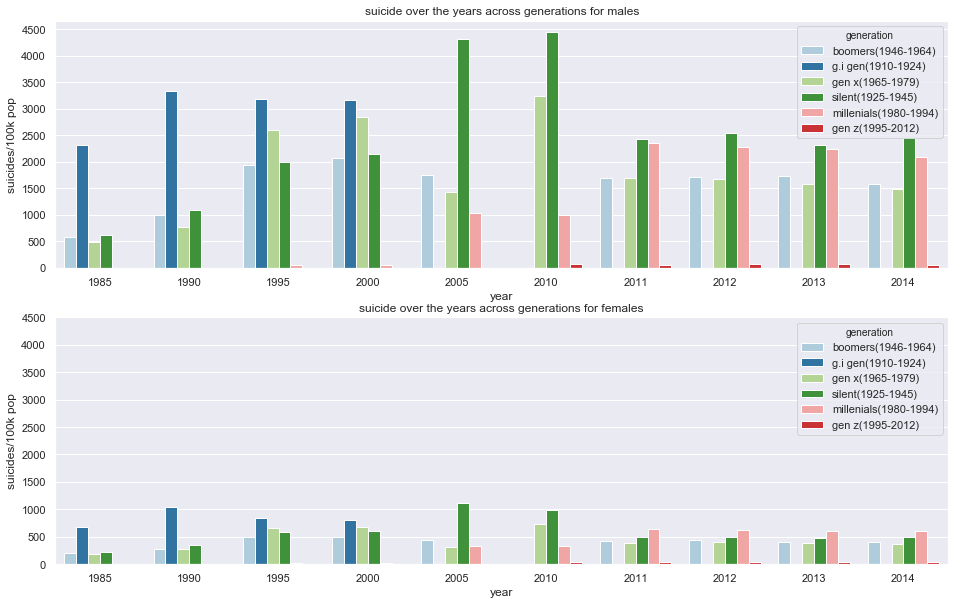

In [7]:
suicide_gen_df = suicide_edit_df.copy()
suicide_gen_df = suicide_gen_df.groupby(['year', 'sex','generation'])['suicides/100k pop'].sum().reset_index()
# splitting genders
suicide_gen_female_df = suicide_gen_df[suicide_gen_df['sex'] == 'female']
suicide_gen_male_df = suicide_gen_df[suicide_gen_df['sex'] == 'male']
# plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (16,10))
sns.barplot(
    data = suicide_gen_male_df, ax = ax1, 
    y = suicide_gen_male_df['suicides/100k pop'], x = suicide_gen_male_df['year'],
    hue = suicide_gen_male_df['generation'], palette = 'Paired'
)
ax1.set_yticks(np.arange(0, 5000, 500))
ax1.set_title('suicide over the years across generations for males')
sns.barplot(
    data = suicide_gen_female_df, ax = ax2,
    y = suicide_gen_female_df['suicides/100k pop'], x = suicide_gen_female_df['year'],
    hue = suicide_gen_female_df['generation'], palette = 'Paired'
)
ax2.set_title('suicide over the years across generations for females')
ax2.set_yticks(np.arange(0, 5000, 500))
plt.show()

### Findings 3: How does the suicide rate vary across generations? Do people in my generation (gen z) commit the deed more often? 
- I observe that from the graph above that in general, people commit suicide as they get older as seen from boomers, gi gen, gen x.
- However, it is disturbing to see that in recent years, the number of millenials committing suicide rivals that of the older generations. The suicide numbers of female millenials are the highest in the female category for committing suicide. For both males and females, the number of suicides increased 3 and 2 times respectively from 2010 to 2011. The suicide rate is maintained at that number for the next few years. 
- From the data set, it's difficult to tell how gen z will fare as they are all still very young. Suicidal instincts tend to kick in as one becomes more self aware, which is at an older age. Taking reference from millenials, it might take around 10 more years to see results. 
- Not sure why, but many silent gen people committed suicide in 2005 and 2010.
- On an overall, the silent generation commits the most number of suicide in the past years. However, the rate at which millenials commit suicides is alarming.


### 4) Use the columns to predict suicide number 

In [124]:
suicide_predict_df = suicide_edit_df.copy()
# perform groupby to get the values I want 
suicide_new_df = suicide_predict_df.groupby(['country','year', 'sex', 'age','gdp_per_capita ($)','HDI for year','generation'])['suicides_no','population'].sum().reset_index()
suicide_new_df.head()
suicide_new_df = pd.get_dummies(suicide_new_df, prefix_sep = '_', drop_first = True)
suicide_new_df.head()
# prepare train, and test data
X = suicide_new_df.loc[:, suicide_new_df.columns != 'suicides_no']
y = suicide_new_df['suicides_no']

In [125]:
# split the train, test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 0
)
trained_model = sm.OLS(y_train, X_train).fit()
print(trained_model.summary())
# create dataframes out of the test, and predicted vaules
y_pred = trained_model.predict(X_test)
y_test = y_test.reset_index()
y_pred = y_pred.reset_index(name = 'predicted values')
y_test['y_pred'] = y_pred['predicted values']

                            OLS Regression Results                            
Dep. Variable:            suicides_no   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     115.2
Date:                Sun, 14 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:04:50   Log-Likelihood:                -46405.
No. Observations:                6273   AIC:                         9.302e+04
Df Residuals:                    6169   BIC:                         9.372e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


C:\Users\User\Documents\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


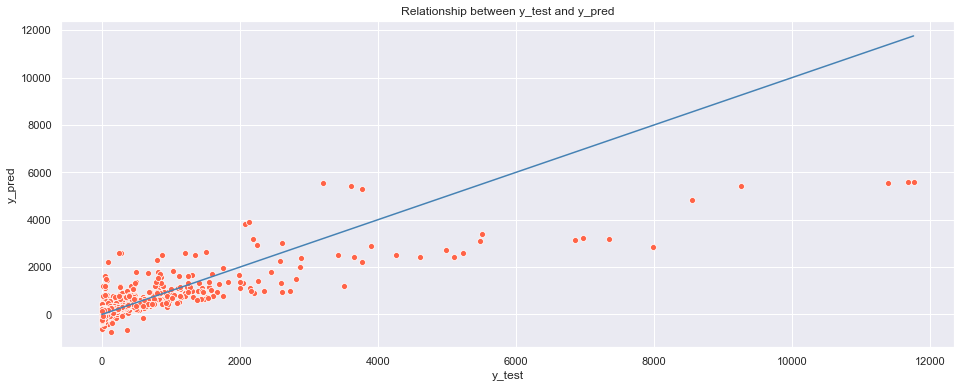

In [122]:
y_test.head()
fig, ax1 = plt.subplots(figsize = DIMS)
sns.scatterplot(
    ax = ax1, color = 'tomato',
    x = y_test['suicides_no'], y = y_test['y_pred']
)
sns.lineplot(
    ax = ax1, color = 'steelblue',
    x = y_test['suicides_no'], y = y_test['suicides_no']
)
ax1.set_title('Relationship between y_test and y_pred')
ax1.set_ylabel('y_pred')
ax1.set_xlabel('y_test')
plt.show()

- The red dots represent the plot between y_test and y_pred while the blue line represents the line of best fit. The closer the red dots are to the steelblue line, the more accurate the prediction.
- The prediction is pretty on point for values 0-2000. The red dots in that range are quite close to the steelblue line. At higher values, the prediction goes off, but probably due to the small amount of data that it has to work with. So, well done ML!

## Findings
1) Are females more likely to commit suicide in general? 
- Nope. Males turn out to be the mentally weaker species. But why though? It's a problem that consists of many possible factors. If more in-depth research were to be put into finding out why men are weaker, one can analyse the mental frames or cultural identities of each gender. This could be found out by taking a survey among men and women, asking the same questions about their stress levels, expectations in life... etc. Difficult to find out an answer to 1) in my opinion. Too many factors that may very well be emotional. Even though we get the answer to the survey, there may be many internal biases in the data collection.

2) How does suicide rate vary with the developness of a country? 
- Depends on what one considers as developed. Is a richer considered more developed? Or one with better health care, education? But it is a false assumption to think that a richer country (which is what people usually associate with developness. That is now debunked) will have less people who feel any less pressured to commit suicide.
- Both the first world, and third worlds have their own set of problems that lead people to commit the deed. To really find out the reasons for the results, we need more data on what goes on at the ground level. This data set is on a very macro level. There's so much more that can be analysed. Like their day-to-day life, culture, geography of hospitals, percentage of uni graduates, number of jobs... etc. 

3) How does the suicide rate vary across generations in recent years? Do people in my generation (gen z) commit the deed more often? 
- Unfortuntely, it seems that young people these days seem to be more reckless, as that's what the analysis tells me. However, one cannot conclude so simply, because the data is incomplete. The data set does not contain information about the older generation in their younger days. 
- I cannot see if gen z people commit suicide more often because I don't have the data for that as well. I do suppose I can try predicting. But even so, there are many variables that isn't considered in this data set, that a prediction will be inaccurate. 
- It will be worth conducting further research as to why millenials are more reckless now. This could be due to the increased exposure of media, education ... etc.  Also, the 2005 and 2010 surge in suicides from the silent generation is worth finding out. A bit strange why the number of suicides shot up by so much. I can't really guess reasons for that. 

4) So how do these columns indicate how likely people are to commit suicide? Can I predict them?
- I predicted them via OLS regression. I intially made the mistake of manually converting strings into integers. My rationale was: If the ML algorithm only takes in numbers, just change all the strings to integers. Then I could feed the data in the ML model. But after consulting one of the TAs, I realised that it's not correct to do that, since the integers also serve as values. It's wrong to replace the categorical variables with integers, because the meaning of the variables will change. So I used pd.get_dummies to make dummy variables and fed the variables into the model instead. 
- The prediction pretty accurate between suicides between 0-2000. So yes. The suicides can be successful predicted.

### Hypothesis & Answers

1) I think more females commmit suicide. Nope

2) Higher suicide rates are more likely from poorer countries. Yes.

3) The highest suicide rates is probably from the silent generation. Yes.